In [136]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [138]:
returns = pd.read_csv('/Users/liyihan/Desktop/Work/ASL/ETF Hedging Data/retuns.csv')
returns.set_index('Date', inplace=True)
etf_returns = returns.iloc[:, :4]
future_returns = returns.iloc[:, 4:10]
risk_free_rate = returns.iloc[:, 10:]

In [139]:
def rolling_regression(etf_returns, future_returns, window):
    hedge_ratios = pd.DataFrame(index=etf_returns.index, columns=etf_returns.columns)
    pca_components = {}
    
    for end in range(window, len(etf_returns)):
        start = end - window
        etf_window = etf_returns.iloc[start:end]
        future_window = future_returns.iloc[start:end]
        
        # 标准化期货收益率数据
        future_standardized = (future_window - future_window.mean()) / future_window.std()
        
        # 进行主成分分析
        pca = PCA(n_components=3)
        pca_futures = pca.fit_transform(future_standardized)
        
        # 保存PCA成分
        pca_components[end] = pca.components_
        
        for etf in etf_returns.columns:
            etf_return = etf_window[etf]
            model = sm.OLS(etf_return, sm.add_constant(pca_futures))
            results = model.fit()
            hedge_ratios.loc[etf_returns.index[end], etf] = results.params[1:].tolist()
    
    return hedge_ratios, pca_components

window_size = 252
hedge_ratios, pca_components = rolling_regression(etf_returns, future_returns, window_size)


In [140]:
def build_hedge_strategy(hedge_ratios, future_returns, pca_components, window):
    hedge_portfolio = pd.DataFrame(index=hedge_ratios.index, columns=hedge_ratios.columns)
    
    for end in range(window, len(future_returns)):
        start = end - window
        future_window = future_returns.iloc[start:end]
        
        # 标准化期货收益率数据
        future_standardized = (future_window - future_window.mean()) / future_window.std()
        
        for etf in hedge_ratios.columns:
            hedge_ratio = hedge_ratios.loc[hedge_ratios.index[end], etf]
            pca_component = pca_components[end]
            future_weights = np.dot(pca_component.T, hedge_ratio)
            hedge_portfolio.loc[hedge_ratios.index[end], etf] = np.dot(future_weights, future_returns.iloc[end])
    
    return hedge_portfolio

hedge_portfolio = build_hedge_strategy(hedge_ratios, future_returns, pca_components, window_size)


In [142]:
def calculate_strategy_metrics(etf_returns, hedge_portfolio, risk_free_rate):
    metrics = pd.DataFrame(index=etf_returns.columns, columns=['Average Daily Return', 'Volatility', 'Sharpe Ratio'])
    strategy_returns = etf_returns.sub(hedge_portfolio)
    for etf in etf_returns.columns:
        avg_daily_return = strategy_returns[etf].mean()
        excess_daily_return = strategy_returns[etf] - risk_free_rate['Rf']
        volatility = strategy_returns[etf].std()
        sharpe_ratio = excess_daily_return.mean() / volatility 
        
        metrics.loc[etf, 'Average Daily Return'] = avg_daily_return
        metrics.loc[etf, 'Volatility'] = volatility
        metrics.loc[etf, 'Sharpe Ratio'] = sharpe_ratio
    
    return metrics


strategy_metrics = calculate_strategy_metrics(etf_returns, hedge_portfolio, risk_free_rate)
print(strategy_metrics)


     Average Daily Return Volatility Sharpe Ratio
BILS             -0.00001    0.00073    -0.214232
IED             -0.000326   0.005809    -0.081851
TLT             -0.000719    0.01135    -0.076828
BIL              0.000007   0.000707    -0.197689


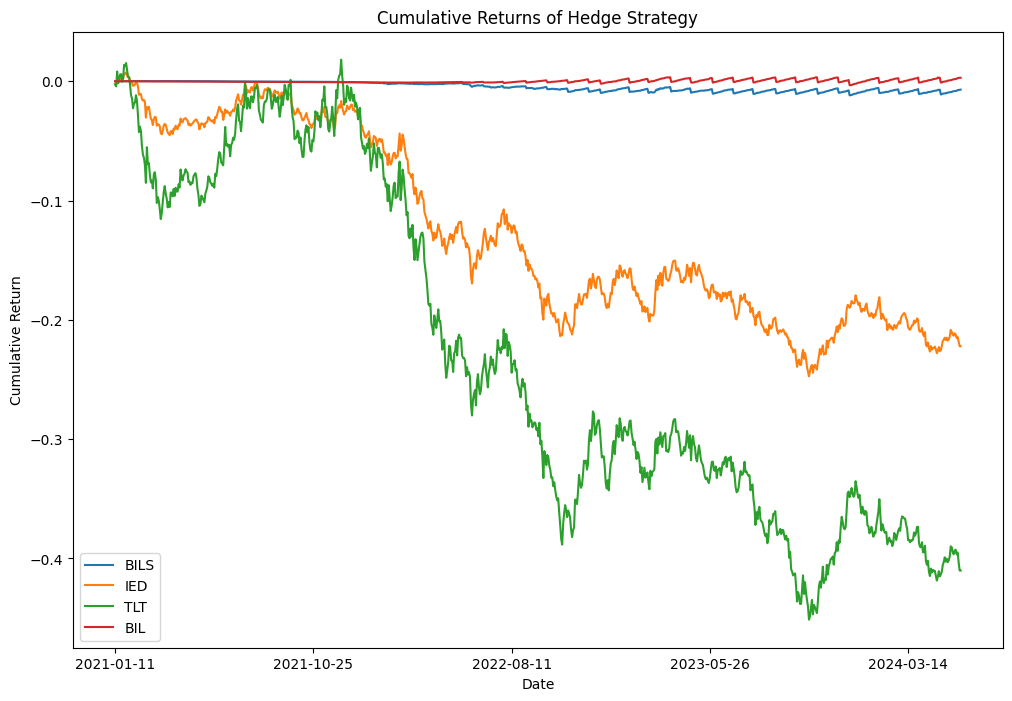

In [143]:
def backtest_strategy(etf_returns, hedge_portfolio):
    strategy_returns = etf_returns.sub(hedge_portfolio, fill_value=0)
    cumulative_returns = (1 + strategy_returns).cumprod()-1
    cumulative_returns.plot(figsize=(12, 8))
    plt.title('Cumulative Returns of Hedge Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.show()
    
    return strategy_returns

strategy_returns = backtest_strategy(etf_returns, hedge_portfolio)

In [109]:
hedge_portfolio.iloc[:50,:]

,BILS,IED,TLT,BIL
Date,,,,
2021-01-11,NaN,NaN,NaN,NaN
2021-01-12,NaN,NaN,NaN,NaN
2021-01-13,NaN,NaN,NaN,NaN
2021-01-14,NaN,NaN,NaN,NaN
2021-01-15,NaN,NaN,NaN,NaN
2021-01-19,NaN,NaN,NaN,NaN
2021-01-20,NaN,NaN,NaN,NaN
2021-01-21,NaN,NaN,NaN,NaN
2021-01-22,NaN,NaN,NaN,NaN
